#### Project Description
Optiver, a globally renowned high-frequency trading company, is organizing a Kaggle competition focused on discovering optimal volatility prediction models. The objective is to forecast short-term volatility for numerous stocks spanning various sectors. With access to millions of rows of detailed financial data, the challenge is to anticipate volatility over 10-minute intervals.


In [1]:
# !pip install kaggle
# !pip install pyarrow
# !pip install statsmodels
# !pip install xgboost
# !kaggle competitions download -c optiver-realized-volatility-prediction
# ! mkdir input
# ! mv optiver-realized-volatility-prediction.zip input/
# ! cd input && unzip -o optiver-realized-volatility-prediction.zip
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import multiprocess as mp
from functools import reduce
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os

########  USEFUL FUNCTIONS  ################

files = []
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
print (' ---  loading %d   files --- '%(len(files)))


 ---  loading 230   files --- 


In [2]:
"""formula """
def WAP1(book):
    return(book.bid_price1*book.ask_size1 + book.ask_price1*book.bid_size1) / (book.bid_size1 + book.ask_size1)

def WAP2(book):
    return(book.bid_price2*book.ask_size2 + book.ask_price2*book.bid_size2) / (book.bid_size2 + book.ask_size2)

def make_title(x):
    return '**'*10+ '  ' +x +'  '+'**'*10+'\n'

def get_price(stock_id, book_trade, train_test='train'):
    return [f for f in files if f'stock_id={stock_id}/' in f and book_trade in f and train_test in f]


#### About the Data
The dataset contains information from 3830 10-minute segments, which have been sampled from a total of 32767 10-minute segments across 112 stocks from 3 years historical trading data.

Data Provided:
- input/book_train.parquet:  order book data
- input/trade_train.parquet: trade data


target - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.
**we only need to predict for stock id 0**

row_id - Unique identifier for the submission row. There is one row for each existing time ID/stock ID pair. Each time window is not necessarily containing every individual stock.


stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.

time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.

bid_price[1/2] - Normalized prices of the most/second most competitive buy level.

ask_price[1/2] - Normalized prices of the most/second most competitive sell level.

bid_size[1/2] - The number of shares on the most/second most competitive buy level.

ask_size[1/2] - The number of shares on the most/second most competitive sell level.



In [3]:
train = pd.read_csv('input/train.csv')
book_example = pq.read_table(get_price(0, 'book')[0]).to_pandas()
trade_example = pq.read_table(get_price(0, 'trade')[0]).to_pandas()

print(make_title('target - y_true'),train.head())
print (make_title('order book example '),book_example.head(3))
print (make_title('trade example '),trade_example.head(3))


stock_ids = train.stock_id.unique()
np.random.seed(42) 
np.random.shuffle(stock_ids)
test_ids, train_ids  = stock_ids[0:28], stock_ids[28::]
print('\nstock_ids: total number of stocks: %d '%(len(stock_ids)))
print ('number of train_ids', len(train_ids))
print('test id :',test_ids)

********************  target - y_true  ********************
    stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747
********************  order book example   ********************
    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2   
0        5                  0    1.001422    1.002301     1.00137    1.002353  \
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          3        226          2        100  
1          3        100          2        100  
2          3        100          2        100  
********************  trade example   ********************
    time_id  seconds_in_bucket     price  size  order_count
0        5                 21  1.002301   326       

#### Formulas
**Realized volatility**
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called volatility.

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the realized volatility,  𝜎 as the squared root of the sum of squared log returns, P as price


$WAP =\text{Weighted Average Price}= \dfrac{P_{bid} \times Size_{ask}+Size_{bid}\times P_{ask}}{Size_{bid}+ Size_{ask}}$

$\sigma=\sqrt{\sum r_{t-1,t}^2} \; , \quad\quad  r_{t1,t2}=log(\dfrac{S_{t2}}{S_{t1}})= log(S_{t2})-log(S_{t1})$

$\text{bid ask spread}= \dfrac{P_{ask}-P_{bid}}{P_{ask}}$
 
Where we use WAP price to compute log returns, P stands for price.


#### EDA
task for week2
1. plot to see calculated realized vol with target in the train set ✓
2. check the correlation ✓
3. Simpler Linear regression ✓
4. Submit 

task for week3-4
1. create a table with index=stock_id, title=time_id, data=[vol1,vol2,vol3,vol4.....], - create an ETF column and see if individual stocks vol is dep on ETF vol  ✓
2. then add ETF col to regression model each time_id, compute mean of vol across all stock_ids
3. then calculate new R-sqr
4. look at the raw data again, try to get more information. e.g first-5-min-vol
5. try to group stocks. try clustering, to see if stock can grouped.


If time_id of stock id 0 and 10 is the same:  True
max time id is  32767 ,  count of time id 3830
********************  book  ********************
    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2   
0        5                  0    1.001422    1.002301     1.00137    1.002353  \
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   
3        5                  6    1.001422    1.002301     1.00137    1.002405   
4        5                  7    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          3        226          2        100  
1          3        100          2        100  
2          3        100          2        100  
3          3        126          2        100  
4          3        126          2        100  
********************  trade  ********************
    time_id  seconds_in_buc

/var/folders/nb/dkj5xcb5285dnpgjlrmzx1xm0000gn/T/ipykernel_75296/4290181327.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book['WAP1']= WAP1(book)
/var/folders/nb/dkj5xcb5285dnpgjlrmzx1xm0000gn/T/ipykernel_75296/4290181327.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book['WAP2']= WAP2(book)


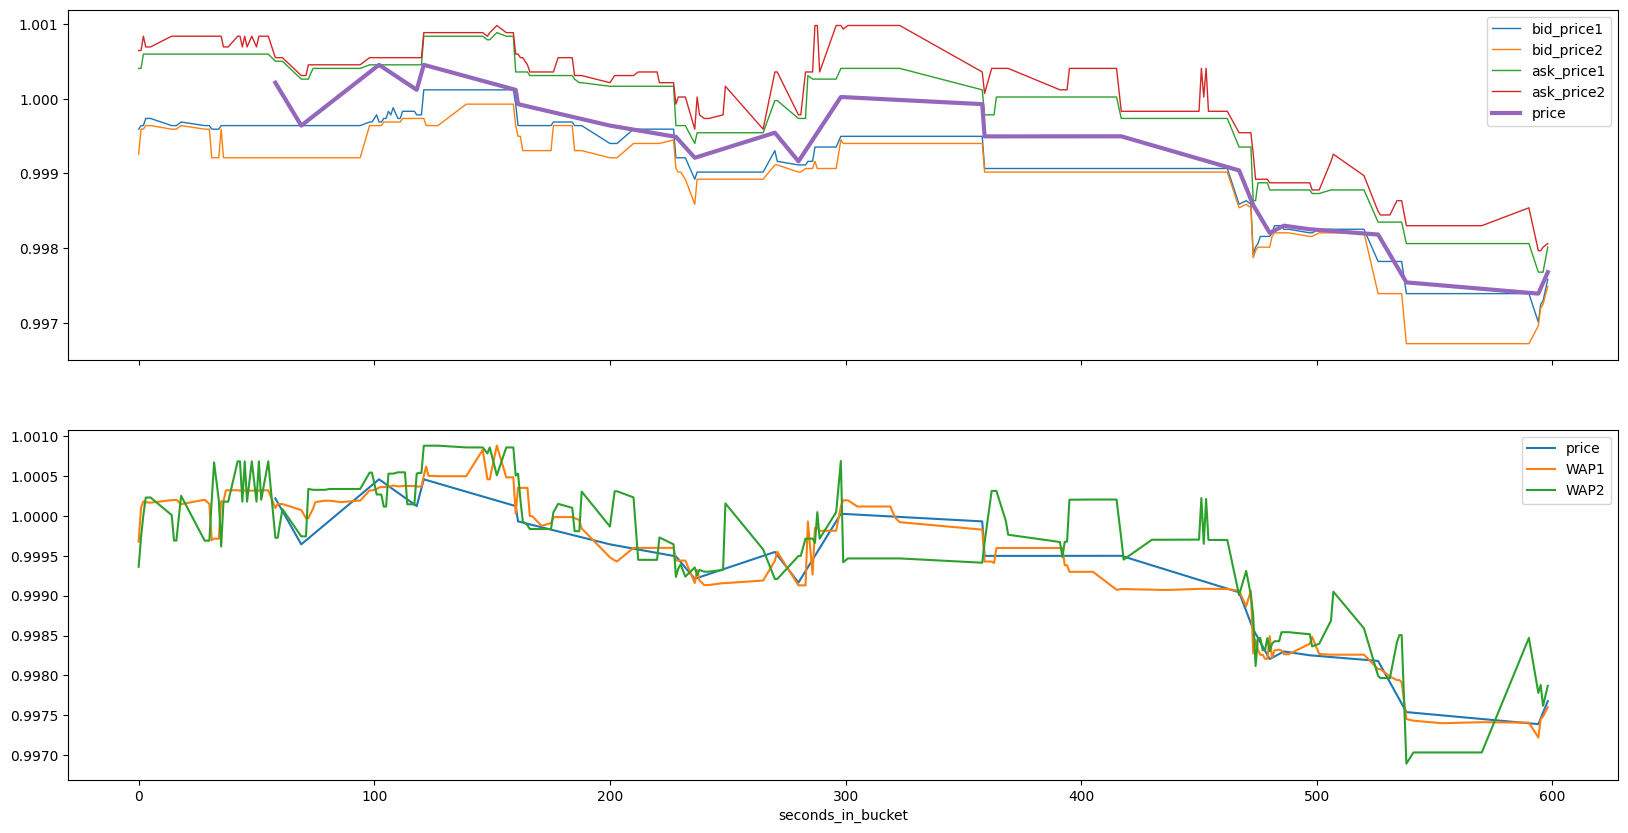

In [31]:
def ref_time_EDA():
    sample0=train.query("stock_id==0")
    sample10=train.query("stock_id==10")
    id_is_same = (sample10['time_id']-sample0['time_id']).abs().sum()
    
    print ('If time_id of stock id 0 and 10 is the same: ',id_is_same==0)
    print ('max time id is ',sample0['time_id'].max(), ',  count of time id' , sample0['time_id'].nunique())
    
def ref_price_EDA(stock_id,time_id): 
    df_book = pq.read_table(get_price(stock_id, 'book')[0]).to_pandas()
    df_trade = pq.read_table(get_price(stock_id, 'trade')[0]).to_pandas()
    print (make_title('book'),df_book.head())
    print (make_title('trade'),df_trade.head())
    book =  df_book.loc[df_book["time_id"]==time_id]
    trade =  df_trade.loc[df_trade["time_id"]==time_id]

    book['WAP1']= WAP1(book)
    book['WAP2']= WAP2(book)
    #[(book, column name, linewidth)]
    samples = [
        (book,'bid_price1',1.0),
        (book,'bid_price2',1.0),
        (book,'ask_price1',1.0),
        (book,'ask_price2',1.0),
        (trade,'price',3.0),
        ]
    
#     plt.figure(figsize=(20,5))
    fig, ax = plt.subplots(nrows=2, ncols=1,  figsize=(20, 10),sharex=True,squeeze=True)

    for num, (bk, col,lw) in enumerate(samples):
        ax[0].plot(bk["seconds_in_bucket"],bk[col],label=col,linewidth=lw)
    ax[0].set_xlabel('seconds')
    ax[0].legend()
#     plt.title('order book prices of stock_id %d time_id %d (10 min period)'%(stock_id, time_id))
#     plt.show()
    
    trade.plot(x='seconds_in_bucket',y='price',ax=ax[1])
    book.plot(x='seconds_in_bucket',y='WAP1',ax=ax[1])
    book.plot(x='seconds_in_bucket',y='WAP2',ax=ax[1])

ref_time_EDA()  
ref_price_EDA(stock_id=0, time_id=16)

Ref 
1. 112 stocks,3 years of data, each data point represents 10 min bucket
2. each 10-min bucket has a corresponding time_id
3. time bins r discontinuous, should not use rolling functions
4. in the 10-mib bucket, not all book or trade has data in every sec. the distribution is different too
5. they will try simple LightGBM

Our takeaways
Machine Learning Procedural Improvements:
1. Read the problem more carefuly, with extra attention to formulae (wap)
2. Plot the data, and plots of meta data to check our assumptions more carefully
3. Read the data again check for accidental overlaps between different sets of data

#### Feature engineering 
##### On order book table and trade: 
Feature engineering is essential to address these challenges. By leveraging fundamental finance concepts such as bid-ask spread and realized volatility, we can generate new features that enhance model performance.

- Price spread: The difference between the bid and ask prices. A larger price spread indicates lower liquidity, which in turn implies potential higher volatility.

- Volume: The total quantity of buy and sell orders. Lower volume suggests lower liquidity, which can lead to potential higher volatility.

- Volume imbalance: The difference between buy and sell volumes. A larger difference indicates a greater imbalance between buying and selling pressure, which implies potential higher volatility.

In [26]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def log_return(series):
    return np.log(series).diff()

def plot_log_return(df, time_id):
    df = df.loc[df['time_id']==5]
    df.plot(x='seconds_in_bucket', y='logret1',title='log return')

def calc_book(stock_id, debug=False):
    """    improvements: calculate following features only using the last 300 sec 
    train_test: str "train" or "test"
    """
    # df_trade = pq.read_table(get_price(stock_id, 'trade')[stock_id]).to_pandas()
    df_book = pq.read_table(get_price(stock_id, 'book')[0]).to_pandas()
#     waited average price
    df_book['wap1']= WAP1(df_book)
    df_book['wap2']= WAP2(df_book)
    df_book['logret1']= df_book.groupby('time_id')['wap1'].apply(log_return).values
    df_book['logret2']= df_book.groupby('time_id')['wap2'].apply(log_return).values
    
    if debug:
        print (make_title('order book'))
        display(df_book.head(3))
        plot_log_return(df_book,time_id=5)

    
    df_book['wap_balance'] = abs(df_book['logret1']-df_book['logret2'])
    df_book['ret_sqr'] = df_book['logret1']**2
    df_book['ret_sqr2'] = df_book['logret2']**2
    
    df_book['price_spread']= (df_book.ask_price1 - df_book.bid_price1 )* 2 / (df_book.ask_price1 + df_book.bid_price1)
    
    df_book['bid_spread'] = df_book['bid_price1']-df_book['bid_price2']
    df_book['ask_spread'] = df_book['ask_price1']-df_book['ask_price2']
    
    df_book['total_volume'] = df_book['bid_size1']+df_book['bid_size2']+df_book['ask_size1']+df_book['ask_size2']
    df_book['volume_spread'] = abs(df_book['bid_size1']+df_book['bid_size2']-df_book['ask_size1']-df_book['ask_size2'])


    df_vol = df_book.groupby(['time_id']).agg \
        (
            vol=('ret_sqr',sum),
            wap = ('wap1',np.mean),
            wap_balance =('wap_balance',np.mean),
            price_spread = ('price_spread',np.mean),
            bid_spread = ('bid_spread',np.mean),
            ask_spread = ('ask_spread',np.mean),
            total_volume=('total_volume',np.mean),
            volume_spread=('volume_spread',np.mean),
        )
    df_vol['vol_300'] = np.sqrt(df_book[df_book.seconds_in_bucket >= 300].groupby(['time_id']).agg(vol300=('ret_sqr',sum))['vol300'])
    df_vol['vol'] = np.sqrt(df_vol['vol'])
    df_vol['stock_id'] = stock_id  
    return df_vol


def processor_book(mode='train'):
    with mp.Pool(4) as pool:
        df_vol= pool.map(calc_book, stock_ids)
    return pd.concat(df_vol, axis=0)


In [8]:
def cal_trade(stock_id):
    df_trade = pq.read_table(get_price(stock_id, book_trade='trade')[0]).to_pandas()
    df_vol = df_trade.groupby(['time_id']).agg \
        (
            price_mean=('price',np.mean),
            price_max = ('price','max'),
            price_min = ('price','min'),
            price_std = ('price', 'std'),
            frequency = ('seconds_in_bucket','count')
        )
    df_vol.loc[df_vol['frequency']<=1,'price_std']=0
    df_vol['stock_id'] = stock_id    
    return df_vol

def processor_trade():
    with mp.Pool(4) as pool:
        df_vol= pool.map(cal_trade, stock_ids)
    df_vol = pd.concat(df_vol, axis=0)
    return df_vol



In [31]:
new_book= processor_book()
print (make_title('new features obtained from order book '))
print (new_book.head(3))
new_trade = processor_trade()
print (make_title('new features obtained from trade data '))
print (new_trade.head(3))
df_out = reduce(lambda  left,right: pd.merge(left,right,on=['stock_id','time_id'],
                                           ), [train, new_book,new_trade])


********************  new features obtained from order book   ********************

              vol       wap  wap_balance  price_spread  bid_spread   
time_id                                                              
5        0.001867  1.001592     0.000016      0.000031    0.000026  \
11       0.000509  1.000455     0.000014      0.000035    0.000026   
16       0.001128  0.999711     0.000018      0.000052    0.000032   

         ask_spread  total_volume  volume_spread   vol_300  stock_id  
time_id                                                               
5         -0.000026   1813.051667     501.715000  0.001292        43  
11        -0.000026   3875.378333    1390.391667  0.000293        43  
16        -0.000032   2202.386288     488.269231  0.000882        43  
********************  new features obtained from trade data   ********************

         price_mean  price_max  price_min  price_std  frequency  stock_id
time_id                                             

##### correlation map
- plot correlation heat map
- check for multicollinearity
- remove columns with high correlations (keep the one that has higher correlation to target)

##### drop stock id and replace with unique properties of the stock

- Since the stock_id represents a unique identifier for each stock, it should not be treated as an input column. Hence, our approach involves utilizing alternative properties to distinguish between stocks, such as average target and average standard deviation.

- split dataframe to train and test based on train_ids and test_ids


Multicollinearity Exists


,target,vol,wap,wap_balance,price_spread,total_volume,volume_spread,vol_300,price_mean,price_max,price_min
target,NaN,0.873782,NaN,NaN,NaN,NaN,NaN,0.879114,NaN,NaN,NaN
vol,0.873782,NaN,NaN,0.889637,NaN,NaN,NaN,0.968499,NaN,NaN,NaN
wap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996770,0.852170,0.855777
wap_balance,NaN,0.889637,NaN,NaN,0.950122,NaN,NaN,0.861125,NaN,NaN,NaN
price_spread,NaN,NaN,NaN,0.950122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_volume,NaN,NaN,NaN,NaN,NaN,NaN,0.885276,NaN,NaN,NaN,NaN
volume_spread,NaN,NaN,NaN,NaN,NaN,0.885276,NaN,NaN,NaN,NaN,NaN
vol_300,0.879114,0.968499,NaN,0.861125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_mean,NaN,NaN,0.996770,NaN,NaN,NaN,NaN,NaN,NaN,0.853418,0.857426
price_max,NaN,NaN,0.852170,NaN,NaN,NaN,NaN,NaN,0.853418,NaN,NaN


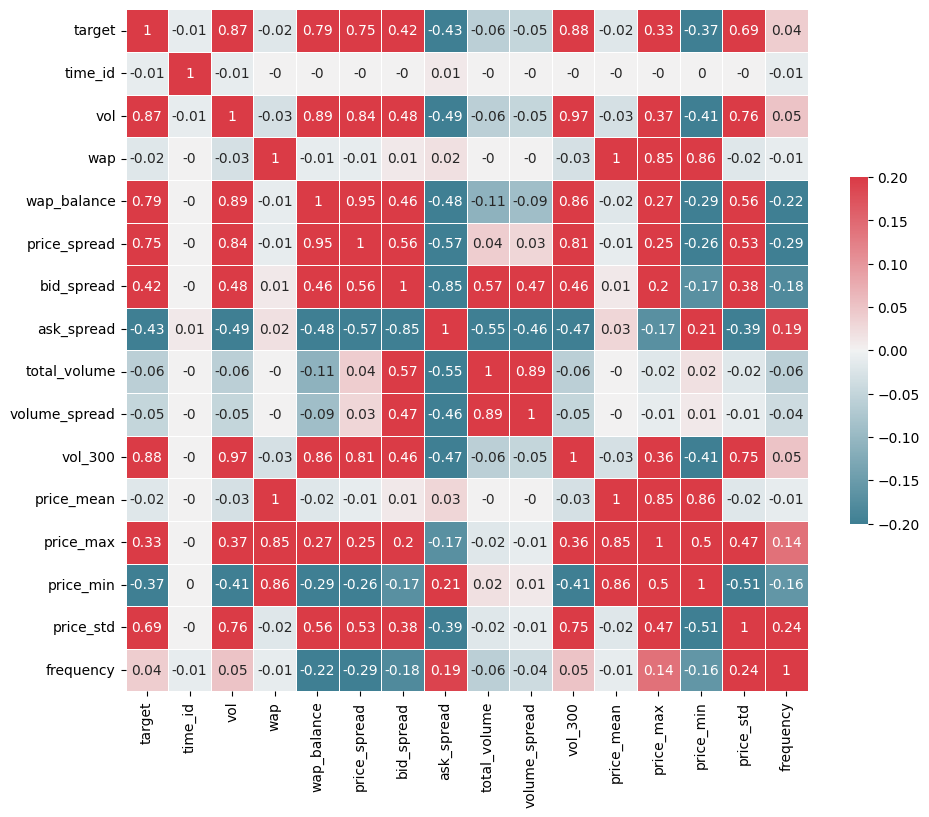

In [77]:
def corr_heatmap(data):
    df = data.copy()
    col = list(df)
    col.remove('stock_id')
    col.remove('target')
    col = ['target']+col
    
    corr = df[col].corr(numeric_only=True)
    err = corr[(abs(corr)>0.85)&(corr<1)].dropna(how="all").dropna(axis="columns",how="all")
    if len(err)>0:
        print('Multicollinearity Exists')
        display (err)
        
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr.round(2), cmap=cmap, vmax=0.2, vmin=-0.2, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
corr_heatmap(df_out)

In [37]:
def processing_train_test(data):
    if data is None:
        book= processor_book()
        trade = processor_trade()
        df = reduce(lambda  left,right: pd.merge(left,right,on=['stock_id','time_id'],
                                               ), [train, book,trade])
    else:
        df = data.copy()
    print ('len: ',len(df))
#      # replace stockid with target mean
    stock_id_target_mean = df.groupby('stock_id')['target'].mean() 
    # drop columns with multicollinearity 
    df_train = df.loc[df['stock_id'].isin(train_ids)]
    df_test = df.loc[df['stock_id'].isin(test_ids)]
    
    y_train, y_test = df_train['target'], df_test['target']
    X_train = df_train.drop(columns=['target'])
    X_test = df_test.drop(columns=['target'])
    X_train['stock_id'] = X_train['stock_id'].map(stock_id_target_mean)
    X_test['stock_id'] = X_test['stock_id'].map(stock_id_target_mean)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = processing_train_test(data=df_out)
X_train.columns

len:  428913


Index(['stock_id', 'time_id', 'vol', 'wap', 'wap_balance', 'price_spread',
       'bid_spread', 'ask_spread', 'total_volume', 'volume_spread', 'vol_300',
       'price_mean', 'price_max', 'price_min', 'price_std', 'frequency'],
      dtype='object')

#### Modelling
- Linear Regression
    - t value is coeffient divided by the standard error
- 

In [65]:
import sklearn.metrics as metrics
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV,  train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor


In [66]:
def LRG_model(X_train, X_test, y_train, y_test):
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print ('R square: %.3f'%(metrics.r2_score(y_test, y_pred)))
    print ('Meam absolute error: %.3f '%(metrics.mean_absolute_error(y_test,y_pred)))
    print(est2.summary())
    

# R square: 0.794
# Meam absolute error: 0.001 
LRG_model(X_train, X_test, y_train, y_test)

R square: 0.794
Meam absolute error: 0.001 
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                 7.686e+04
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:45:24   Log-Likelihood:             1.6747e+06
No. Observations:              321676   AIC:                        -3.349e+06
Df Residuals:                  321659   BIC:                        -3.349e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
co

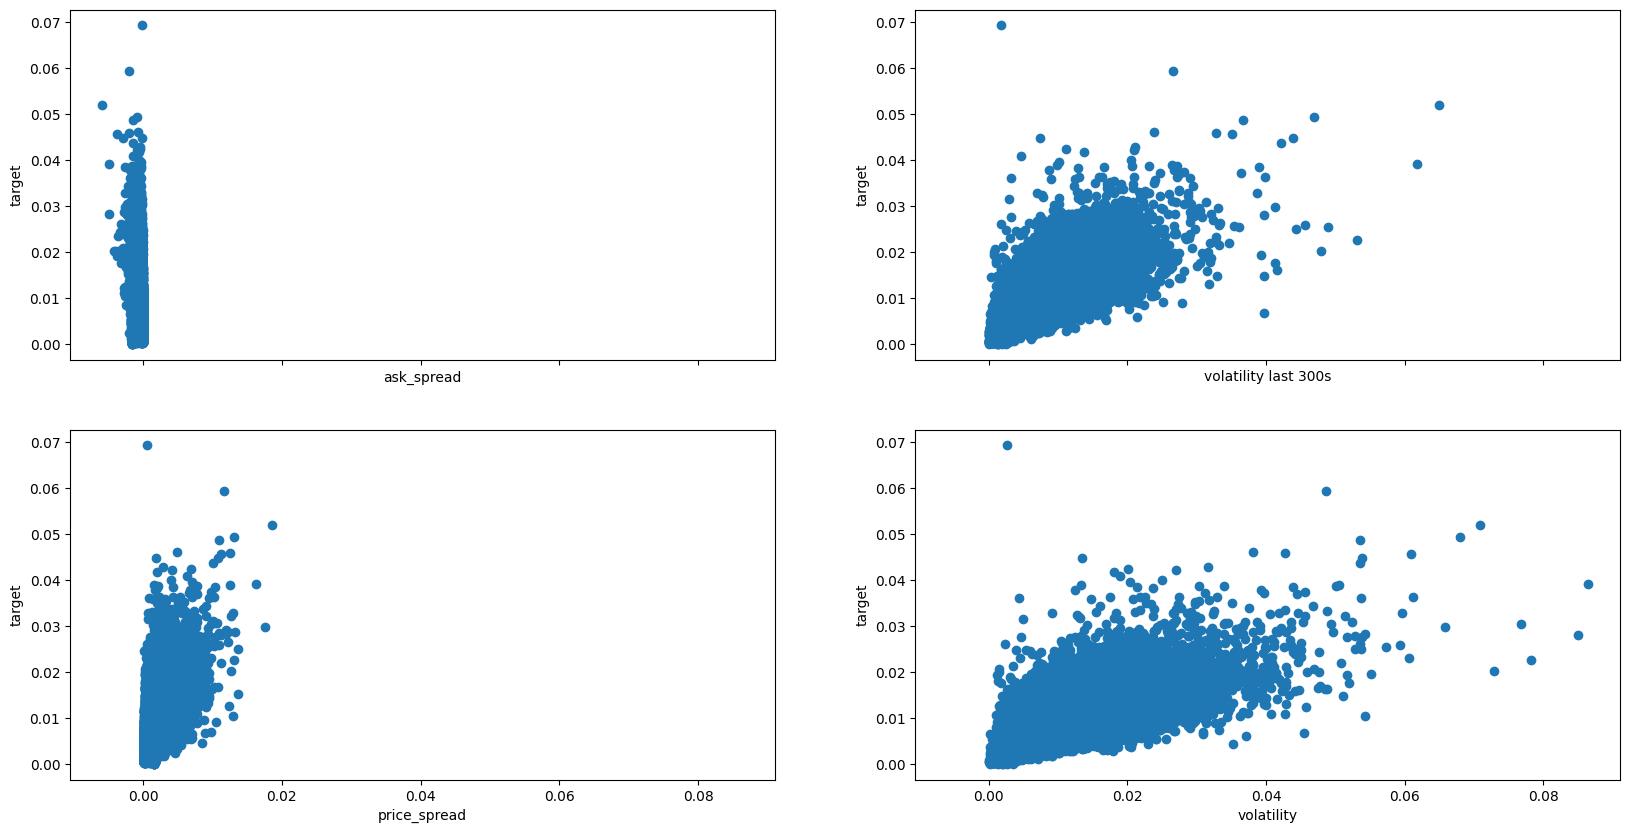

In [67]:
def plot_one_on_one_graph():
    fig, ax = plt.subplots(nrows=2, ncols=2,  figsize=(20, 10),sharex=True,squeeze=True)

    ax[0,0].scatter(X_train['ask_spread'],y_train)
    ax[0,1].scatter(X_train['vol_300'],y_train)
    ax[1,0].scatter(X_train['price_spread'],y_train)
    ax[1,1].scatter(X_train['vol'],y_train)
#     ax[1,0].scatter(X_train['bid_spread'],X_train['ask_spread'])
    ax[0,0].update({'xlabel':'ask_spread', 'ylabel':'target'})
    ax[0,1].update({'xlabel':'volatility last 300s', 'ylabel':'target'})
    ax[1,0].update({'xlabel':'price_spread', 'ylabel':'target'})
    ax[1,1].update({'xlabel':'volatility', 'ylabel':'target'})
    plt.show()
    
    
plot_one_on_one_graph()

In [84]:
# !pip install xgboost

train score 0.8627
test score 0.8112
Fitting 2 folds for each of 12 candidates, totalling 24 fits
0.8106608663529435
{'eta': 0.05, 'gamma': 0, 'max_depth': 10, 'n_estimators': 1000, 'objective': 'binary:logistic'}


AttributeError: module 'sklearn.metrics' has no attribute 'r2_square'

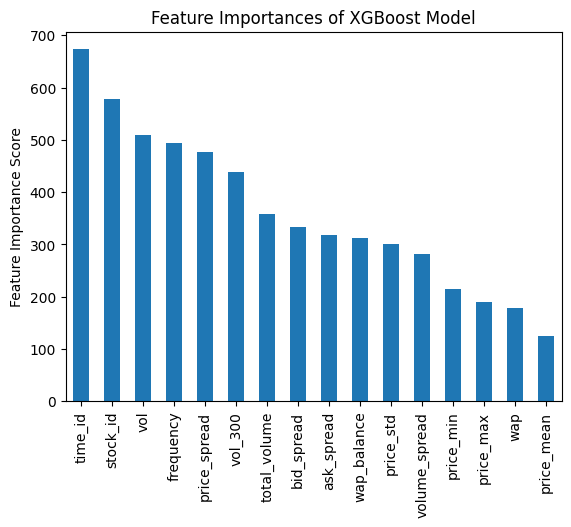

In [79]:
def GradientBoost_model(X_train, X_test, y_train, y_test):  
    model = XGBRegressor()
    gb = model.fit(X_train,y_train)
    y_test_pred = gb.predict(X_test)
    
    print ('train score %.4f'%(gb.score(X_train, y_train)))
    print ('test score %.4f'%(gb.score(X_test, y_test)))
    
    feat_imp = pd.Series(gb.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances of XGBoost Model')
    plt.ylabel('Feature Importance Score')
    
    
    parameters = { 'eta':[0.05,0.1, 0.3, 0.5],
                 'n_estimators':[1000],
                 'gamma':[0],
                 'objective': ['binary:logistic'],
              'max_depth': [3, 5, 10]}
    
    xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    xgb_grid.fit(X_train, y_train)
    y_test_pred = xgb_grid.best_estimator_.predict(X_test)
    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    print ('R2 square test ',metrics.r2_square(y_test,y_test_pred))
    

GradientBoost_model(X_train, X_test, y_train, y_test)

In [ ]:
  
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def testing():
    params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }
    kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
    oof = pd.DataFrame()                 # out-of-fold result
    models = []                          # models
    scores = 0.0                         # validation score

    gain_importance_list = []
    split_importance_list = []
    
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

In [ ]:
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()